# TPC Neutrons
This analysis notebook will be for determining attributes about neutrons counted in the TPC region

In [1]:
import analysis_tools as at
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
neutron_file = h5.File('tpc_data/TPC02240028.hdf5', 'r')

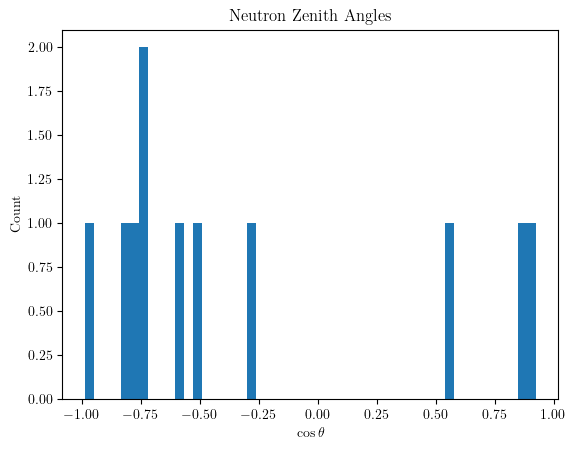

In [11]:
at.plot_coz_neutrons(neutron_file)

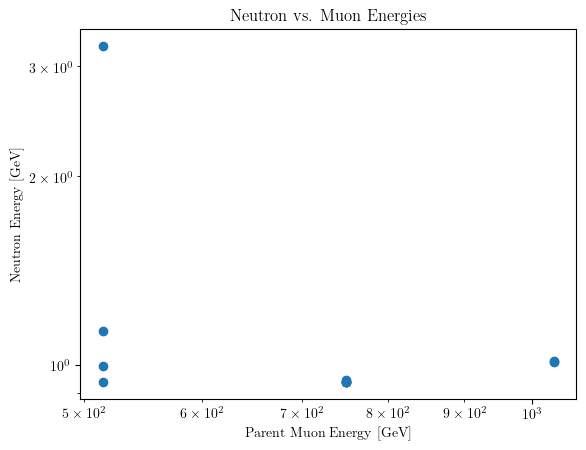

In [12]:
at.plot_e_vs_e(neutron_file)

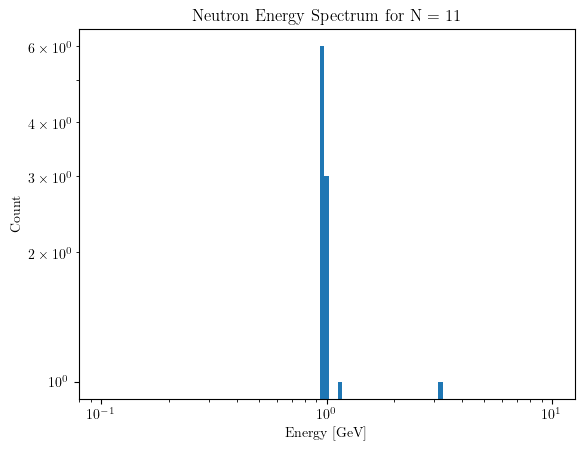

In [13]:
at.plot_neutron_energy_histogram(neutron_file)

In [11]:
def merge_hdf5_files(h5_output, *args):
    '''A function to combine multiple h5 neutron files into a larger file (which may already exist).
    Checks for no duplicates by ensuring scoring regions are equivalent and seeds are different'''

    # Load in the h5 files in read-only mode
    file_list = [h5.File(arg, 'r') for arg in args]

    # Must first confirm these files can be merged. Namely, we need to know if they are scoring the same region and that they are not identical.
    meta_list = [file['meta'] for file in file_list]

    # Checking scoring regions, and seeds
    scoring = [int(m['region'][0]) for m in meta_list]
    seeds = [int(m['seed'][0]) for m in meta_list]

    # Check if the output file already exists and append its attributes to the lists for uniqueness checks

    if not os.path.isfile(h5_output): # The file must be created.
        file = h5.File(h5_output,'a')
        # Create a group for the data
        data = file.create_group('data')
        # Create a group for the meta data (to dilineate different simulation data sets)
        meta = file.create_group('meta')

        # So too must the datasets be created and instantiated with zero size.
        data.create_dataset("muon_energy", (0,), dtype=float, maxshape=(None,))
        data.create_dataset("muon_impact", (0,), dtype=float, maxshape=(None,))
        data.create_dataset("muon_initial", (0,3), dtype=float, maxshape=(None,3))
        data.create_dataset("muon_direction", (0,3), dtype=float, maxshape=(None,3))
        data.create_dataset("muon_pn", (0,), dtype=int, maxshape=(None,))

        data.create_dataset("neutron_energy", (0,), dtype=float, maxshape=(None,))
        data.create_dataset("neutron_generation", (0,), dtype=int, maxshape=(None,))
        data.create_dataset("neutron_xyz", (0,3), dtype=float, maxshape=(None,3))
        data.create_dataset("neutron_direction", (0,3), dtype=float, maxshape=(None,3))

        meta.create_dataset("year",(0,), dtype=int, maxshape=(None,))
        meta.create_dataset("month",(0,), dtype=int, maxshape=(None,))
        meta.create_dataset("day",(0,), dtype=int, maxshape=(None,))
        meta.create_dataset("hour",(0,), dtype=int, maxshape=(None,))
        meta.create_dataset("minute",(0,), dtype=int, maxshape=(None,))
        meta.create_dataset("second",(0,), dtype=int, maxshape=(None,))
        # number of neutrons created in file
        meta.create_dataset("neutrons_counted",(0,), dtype=int, maxshape=(None,))
        # number of muons simulated
        meta.create_dataset("muons_simulated",(0,), dtype=int, maxshape=(None,))
        # number of muons responsible for creating neutrons
        meta.create_dataset("muon_parents",(0,), dtype=int, maxshape=(None,))
        # the integer seed used in the simulation
        meta.create_dataset("seed",(0,), dtype=int, maxshape=(None,))
        # the region scored in the simulation
        meta.create_dataset("region",(0,), dtype=int, maxshape=(None,))

        file.close()

    else:
        file = h5.File(h5_output, 'a')
        for seed in file['meta']['seed']:
            seeds.append(seed)
        
        for region in file['meta']['region']:
            scoring.append(region)
    
        file.close()

    # Make sure the input files are unique simulations with the same region number
    if len(np.unique(seeds)) < len(seeds) or len(np.unique(scoring)) > 1:
        print('INCOMPATIBLE SCORING REGIONS or SAME SEED!')
        return None

    
    # We should be safe to add the attributes of all the other files to the output h5 file now.

    # How much longer does 'data' have to be?
    data_length = 0
    for file in file_list:
        data_length = data_length + len(file['data']['neutron_energy'])

    # How much longer does 'meta' have to be?
    meta_length = 0
    for meta in meta_list:
        meta_length = meta_length + len(meta['seed'])

    # Now we can re-open the output file and resize it as appropriate.

    file = h5.File(h5_output,'a')

    # grabbing the file by the data group
    data = file['data']
    meta = file['meta']

    # Current length of the data in the file
    current_data_size = len(data['neutron_energy'])
    current_meta_size = len(meta['year'])

    # Resizing the datasets in the file by the number of elements we need to append therein.
    for dset in data:
        data[dset].resize(current_data_size + data_length, axis = 0)
    for dset in meta:
        meta[dset].resize(current_meta_size + meta_length, axis = 0)

    meta_index = 0

    for file in file_list:
        temp_data = file['data']
        temp_meta = file['meta']


        for key in data.keys():
            for i in range(len(temp_data['neutron_energy'])):
                data[key][current_data_size + i] = temp_data[key][i]

        for key in meta.keys():
            meta[key][current_meta_size + meta_index] = temp_meta[key][0]

        meta_index += 1 # Goes up by one for every file
        current_data_size += len(temp_data['neutron_energy']) # Goes up an arbitrary amount for every file
    
    for file in file_list:
        file.close()

    file.close()

    # Return the string name of the file
    return h5_output

In [12]:
merge_hdf5_files('test.h5', 'tpc_data/TPC02231242.hdf5', 'tpc_data/TPC02240024.hdf5', 'tpc_data/TPC02241311.hdf5')

'test.h5'

In [17]:
file = h5.File('test.h5')
file1 = h5.File('tpc_data/TPC02231242.hdf5')
file2 = h5.File('tpc_data/TPC02240024.hdf5')
file3 = h5.File('tpc_data/TPC02241311.hdf5')